# 3 Sampling the Imaginary

In [9]:
import arviz as az
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pymc3 as pm
import scipy.stats as stats

In [10]:
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
az.style.use('arviz-darkgrid')

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


**Vampire Test**

#### Code 3.1

$$Pr(vampire|positive) = \frac{Pr(positive|vampire) Pr(vampire)} {Pr(positive)}$$

$$Pr(positive) = Pr(positive|vampire) Pr(vampire) + Pr(positive|mortal) 1 − Pr(vampire)$$

In [11]:
PrPV = 0.95
PrPM = 0.01
PrV = 0.001
PrP = PrPV * PrV + PrPM * (1 - PrV)
PrVP = PrPV * PrV / PrP
PrVP

0.08683729433272395

## 3.1. Sampling from a grid-approximate posterior

#### Code 3.2 - 3.5

We are goint to use the same function we use on chapter 2 (code 2.3)

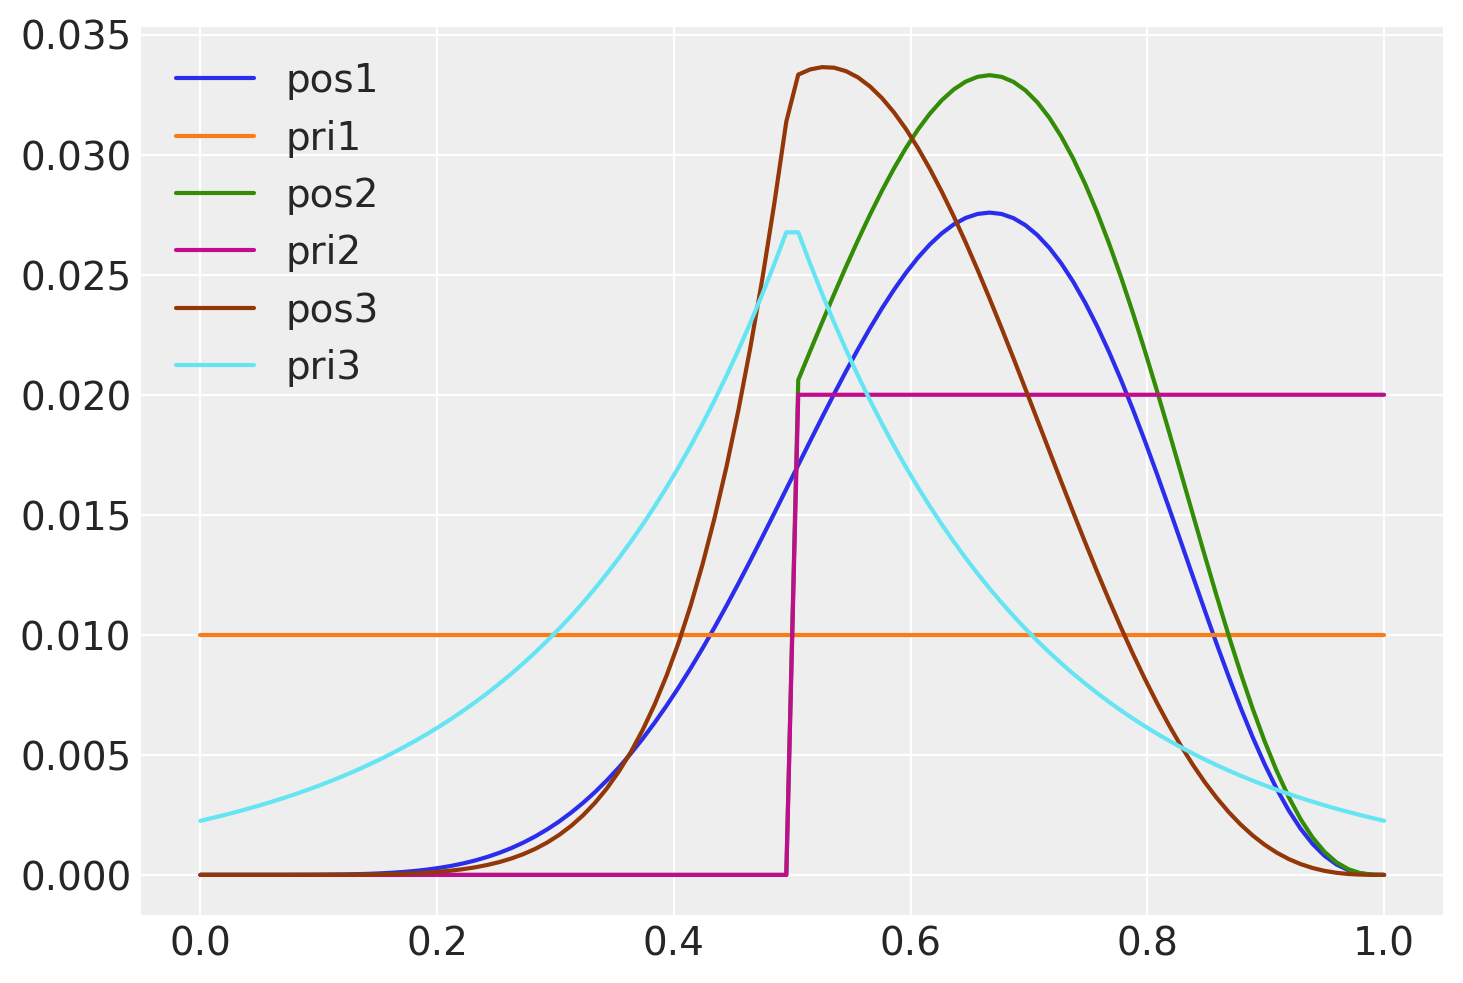

In [40]:
pg=np.linspace(0,1, 100)

prior1 = np.repeat(1, 100) # uniform along pg line
prior2 = (pg >= 0.5).astype(float)
prior3 = np.exp(-5*abs(pg - 0.5))

priors = [p / p.sum() for p in [prior1, prior2, prior3]]

likelihood = stats.binom.pmf(6, 9, pg); likelihood

for i, pri in enumerate(priors):
    pos = likelihood * pri
    pos = pos / pos.sum()

    plt.plot(pg, pos, label=f'pos{i+1}')
    plt.plot(pg, pri, label=f'pri{i+1}')
plt.legend();

In [123]:
def posterior_grid_approx(grid_points=100, success=6, tosses=9, prior_name='uniform'):
    """
    """
    # define grid
    p_grid = np.linspace(0, 1, grid_points)

    # define prior
    if prior_name == 'uniform':
        prior = np.repeat(5, grid_points)  # uniform
    else:
        prior = (p_grid >= 0.5).astype(int)  # truncated
    # prior = np.exp(- 5 * abs(p_grid - 0.5))  # double exp

    # compute likelihood at each point in the grid
    likelihood = stats.binom.pmf(success, tosses, p_grid)

    # compute product of likelihood and prior
    unstd_posterior = likelihood * prior

    # standardize the posterior, so it sums to 1
    posterior = unstd_posterior / unstd_posterior.sum()
    return p_grid, posterior

## Compute Posterior and get posterior samples

In [110]:
p_grid, posterior = posterior_grid_approx(grid_points=100, success=6, tosses=9)
samples = np.random.choice(p_grid, p=posterior, size=int(1e4), replace=True)

In [111]:
p_grid.shape, p_grid

((100,),
 array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
        0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
        0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
        0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
        0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
        0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
        0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
        0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
        0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
        0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
        0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
        0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
        0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
        0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
        0.70707071, 0.71717172, 0.72727

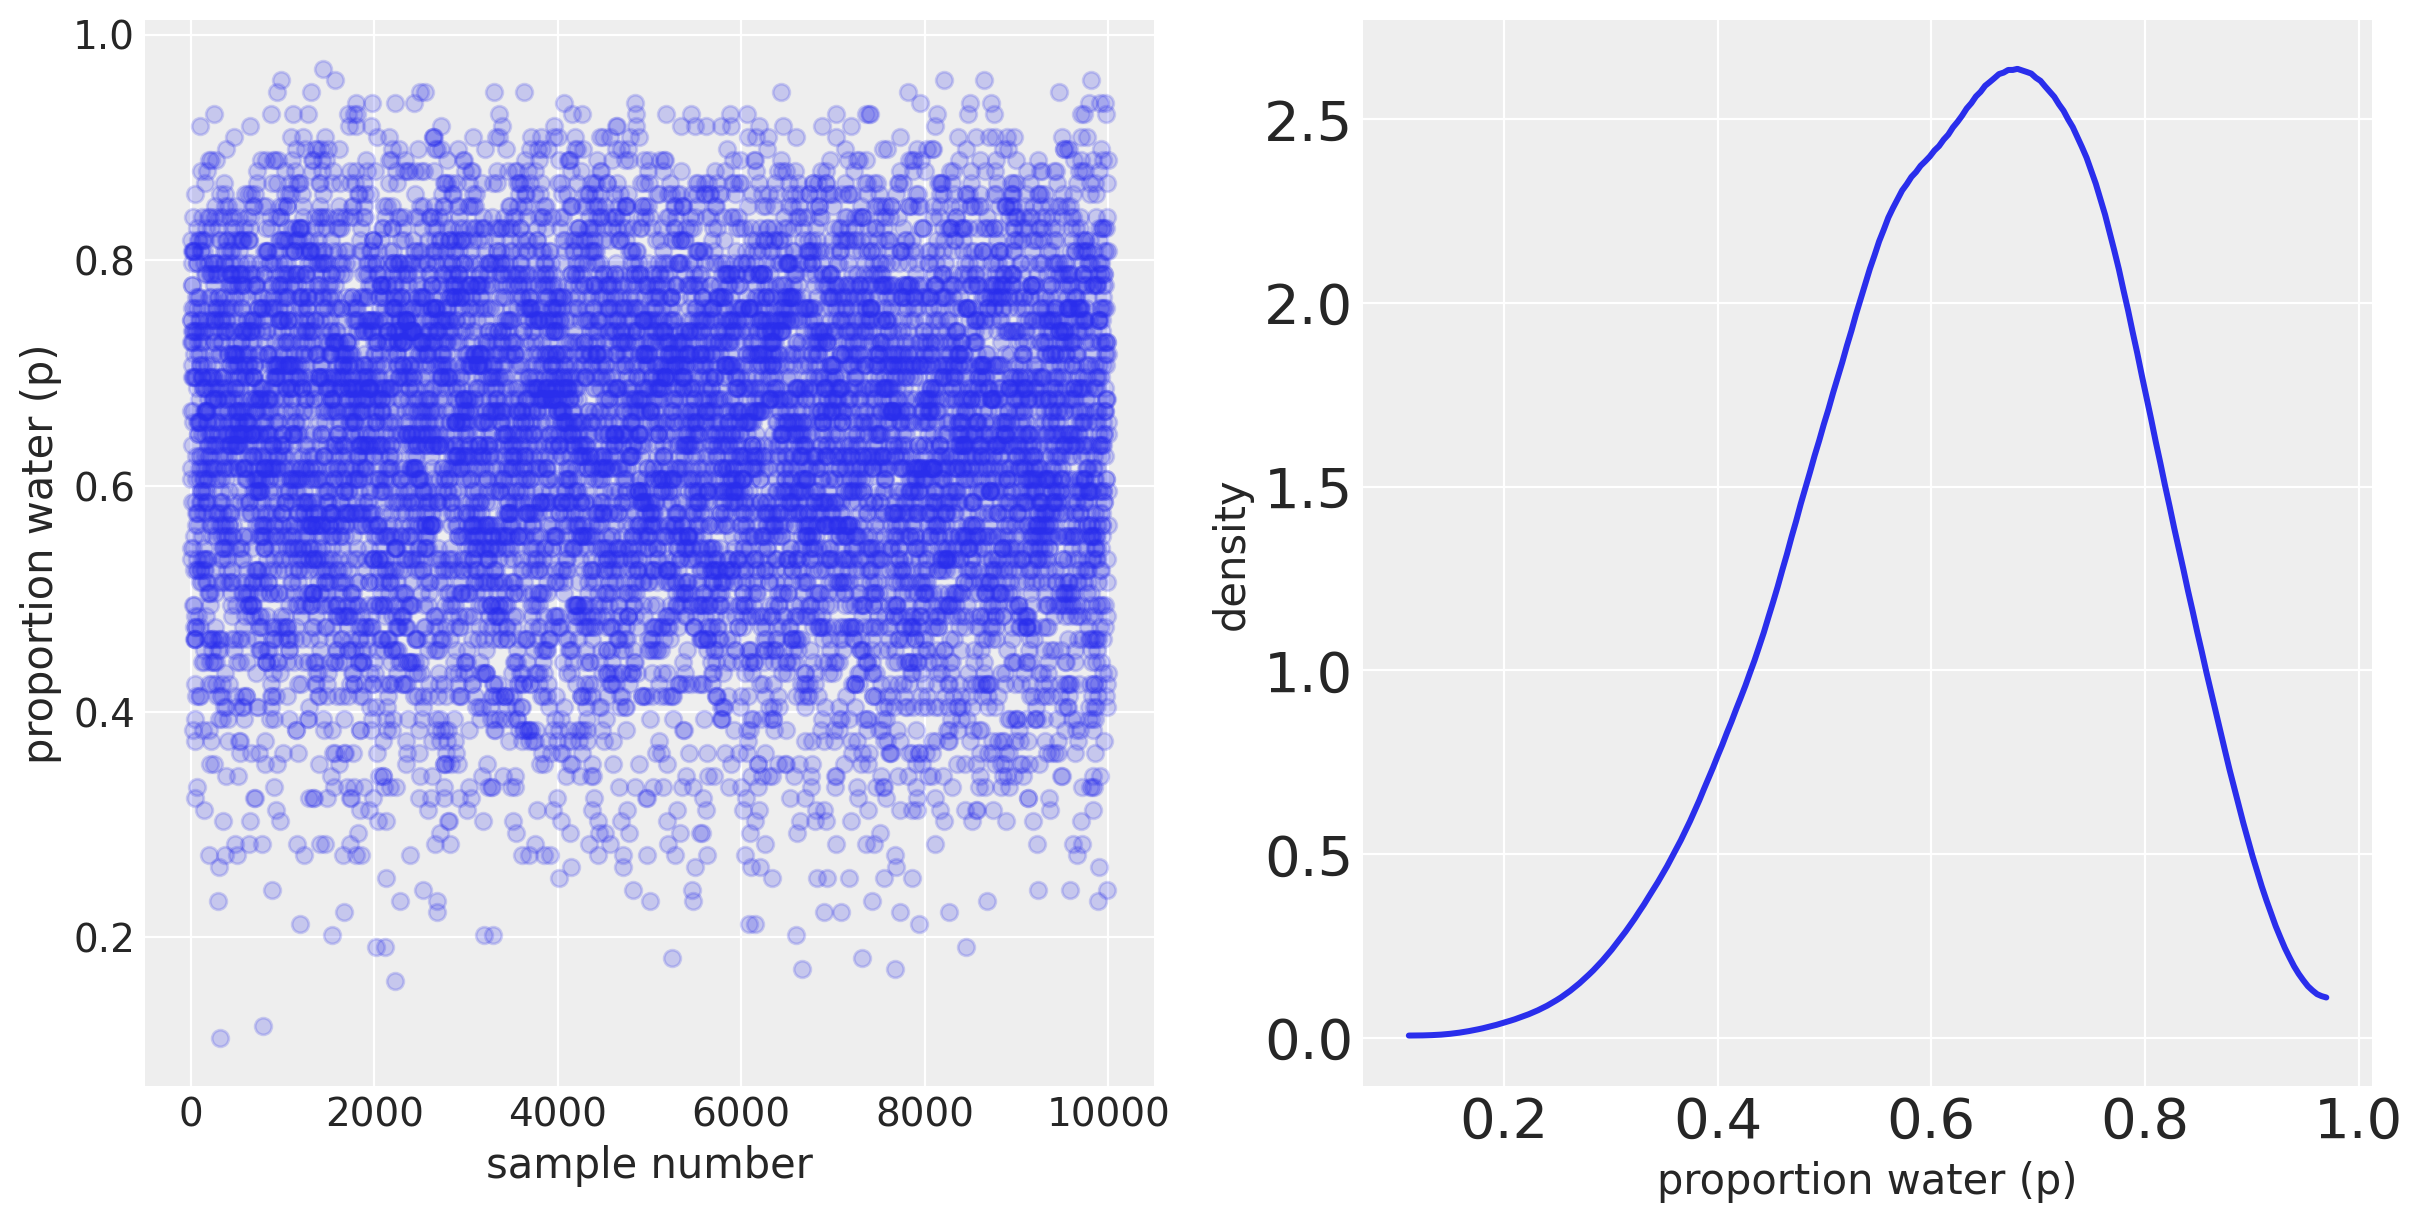

In [112]:
_, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6))
ax0.plot(samples, "o", alpha=0.2)
ax0.set_xlabel("sample number")
ax0.set_ylabel("proportion water (p)")
az.plot_kde(samples, ax=ax1)
ax1.set_xlabel("proportion water (p)")
ax1.set_ylabel("density");

**Minor thing to Noice**
Why not use `plt.hist()`? Each value in p_grid is assumed to be a discrete probability, but `plt.hit()` takes the interval as a unit. So you should use `az.kde()`; however when the size of `p_grid` is large, the shape is almost the same.

In [98]:
p_grid, posterior = posterior_grid_approx(grid_points=10, success=6, tosses=9)
samples = np.random.choice(p_grid, p=posterior, size=int(1e4), replace=True)

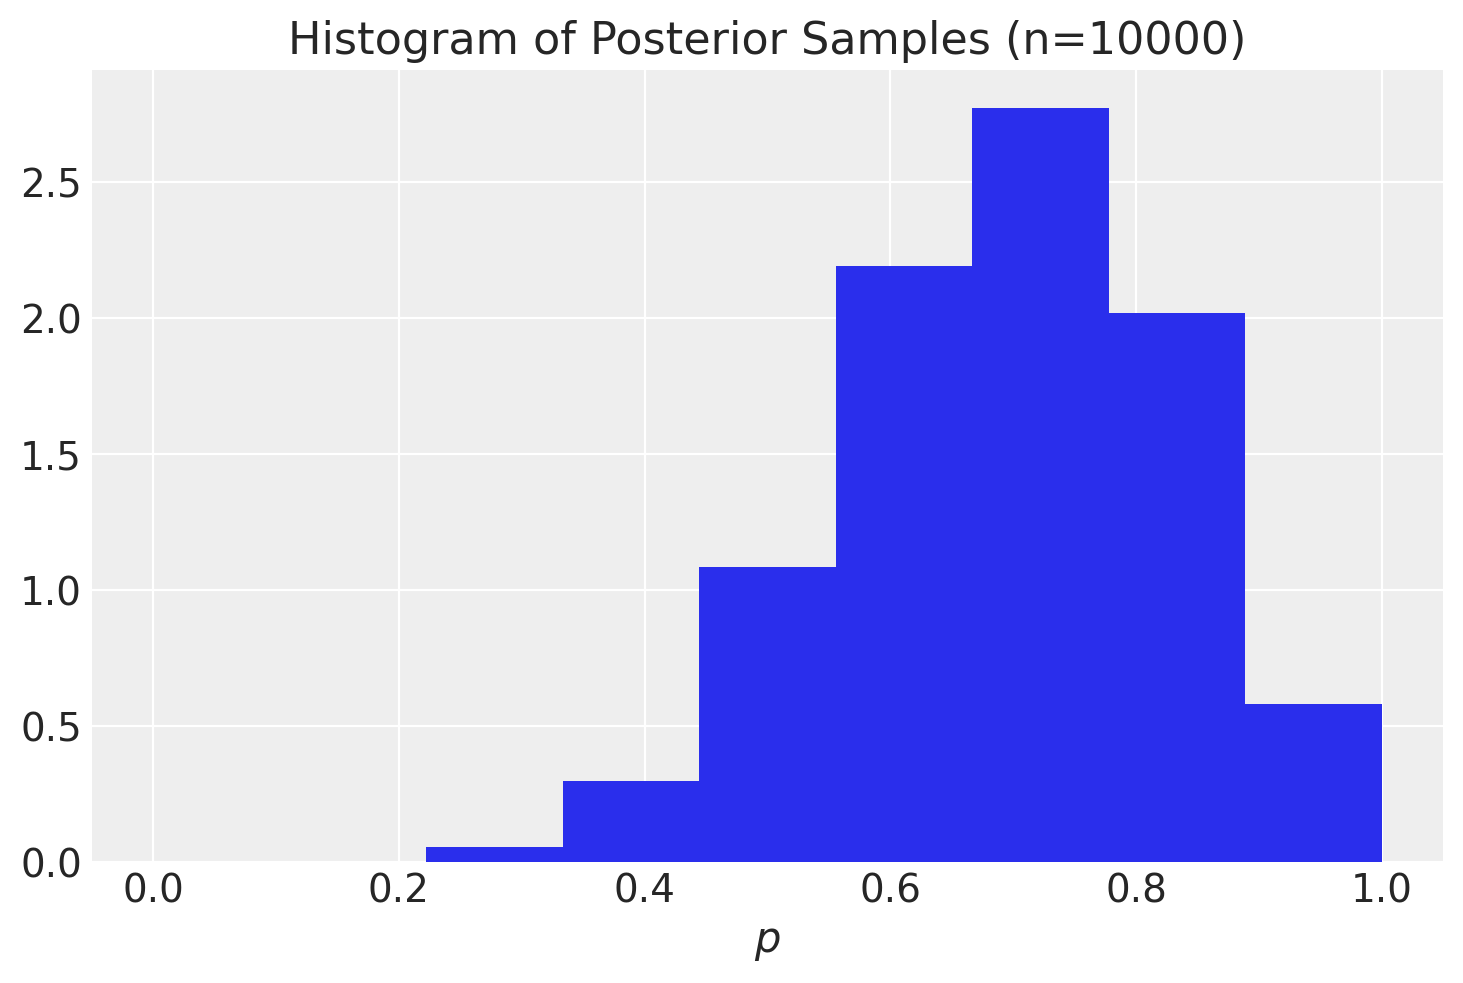

In [99]:
plt.hist(samples, bins=p_grid, density=True);
plt.title(f'Histogram of Posterior Samples (n={len(samples)})');
plt.xlabel('$p$');

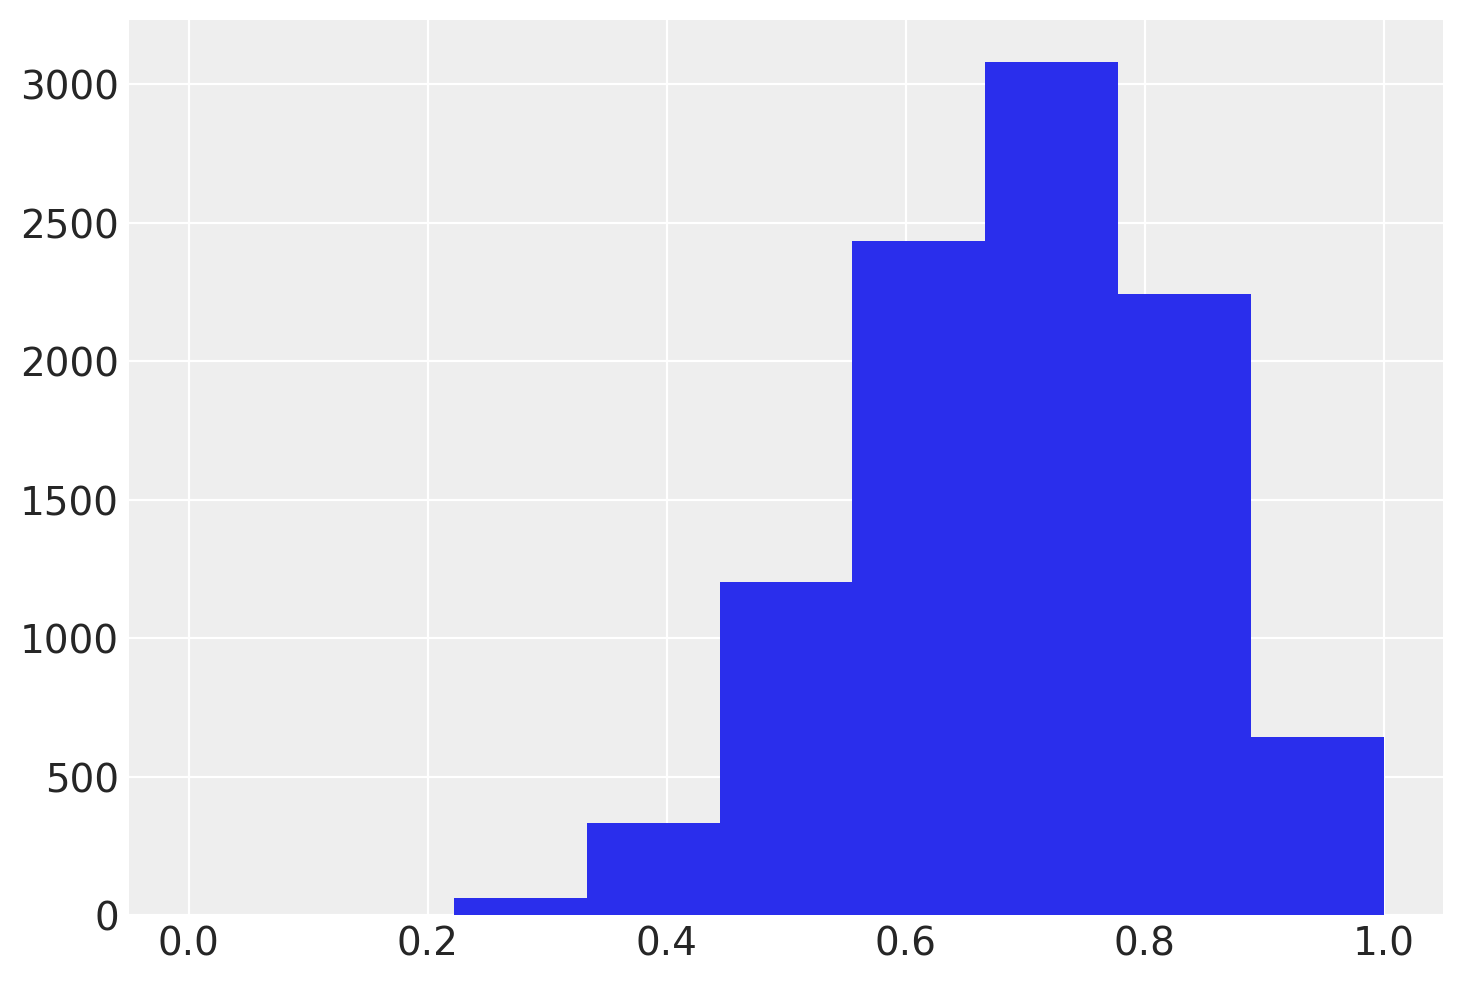

In [100]:
cnt, bins, ax = plt.hist(samples, density=False, bins=p_grid)

In [105]:
cc = cnt / cnt.sum()
cc.shape, p_grid.shape

((9,), (10,))

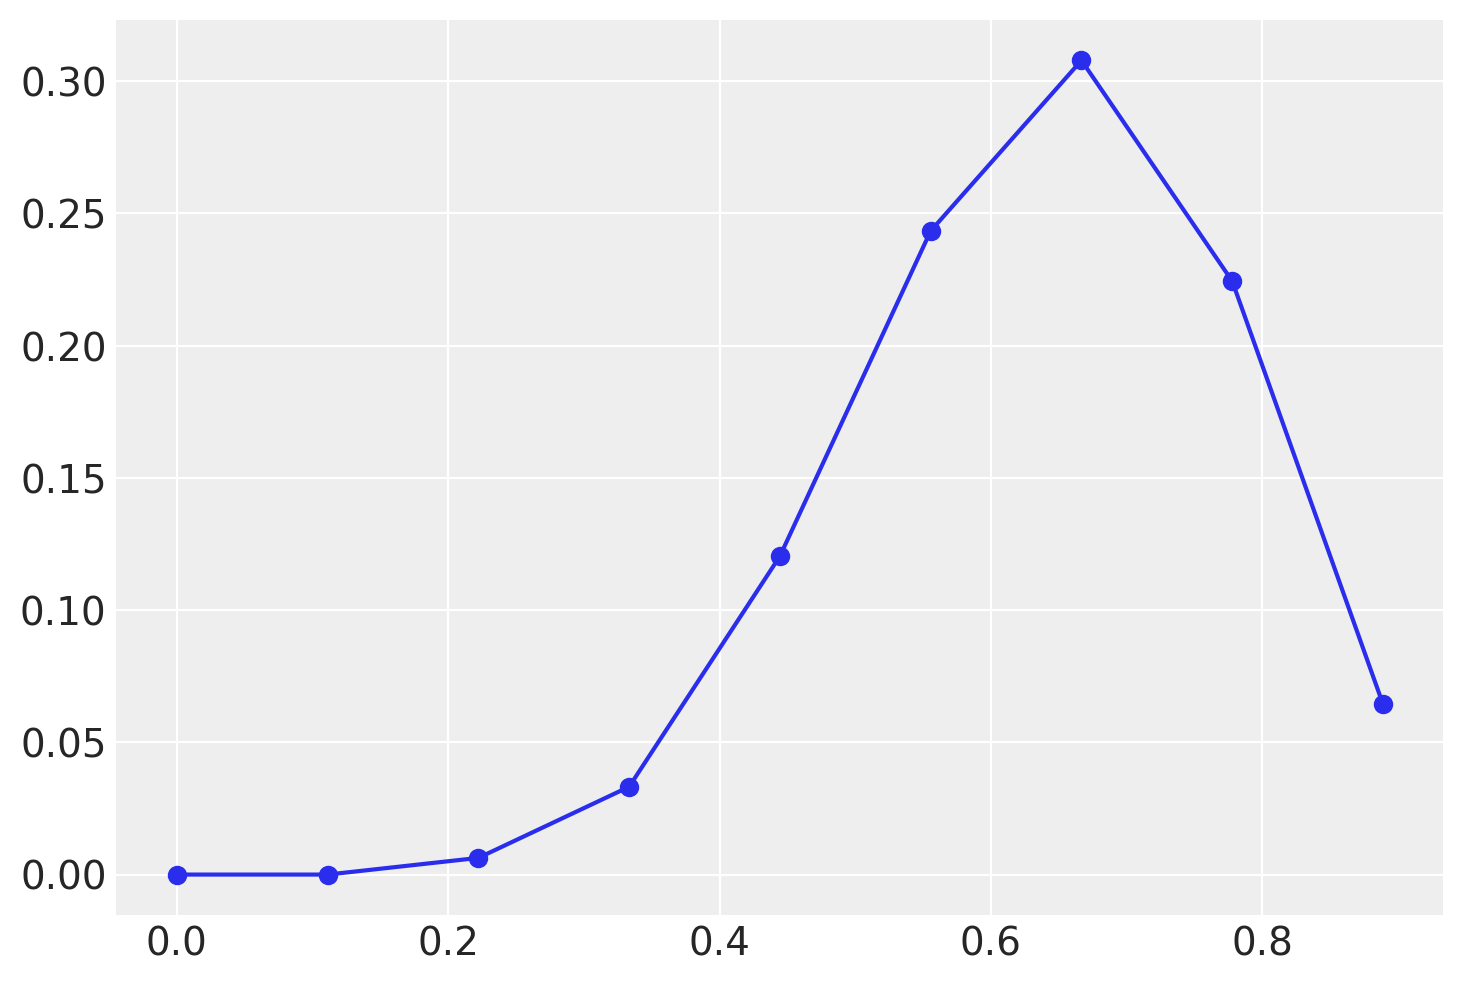

In [104]:
plt.plot(p_grid[:-1], cc, 'o-')

#### Code 3.6

In [113]:
sum(posterior[p_grid < 0.5])

0.17183313110747478

#### Code 3.7

In [114]:
sum(samples < 0.5) / 1e4

0.1761

#### Code 3.8

In [115]:
sum((samples > 0.5) & (samples < 0.75)) / 1e4

0.6039

#### Code 3.9

In [119]:
# 80% point of the sampels
np.percentile(samples, 80)

0.7575757575757577

In [120]:
percentile = 80/100.
per = int(len(samples) * percentile)
np.sort(samples)[per]

0.7575757575757577

#### Code 3.10

In [121]:
np.percentile(samples, [10, 90])

array([0.44444444, 0.80808081])

#### Code 3.11

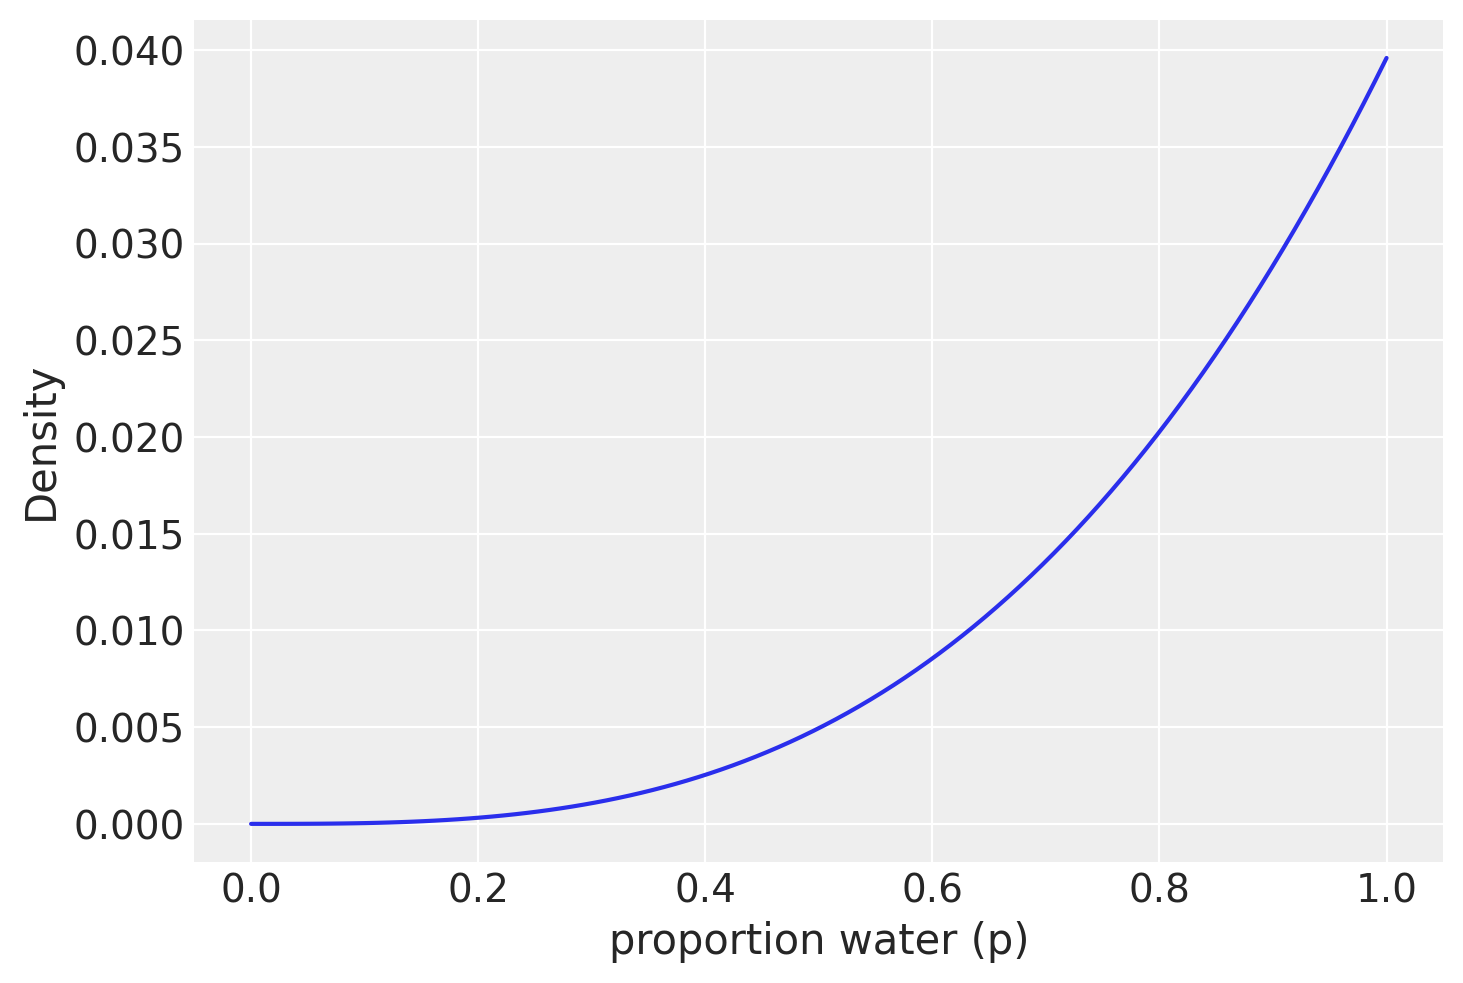

In [126]:
p_grid, posterior = posterior_grid_approx(grid_points=100, success=3, tosses=3, prior_name='uniform')
plt.plot(p_grid, posterior)
plt.xlabel("proportion water (p)")
plt.ylabel("Density");

#### Code 3.12

In [127]:
samples = np.random.choice(p_grid, p=posterior, size=int(1e4), replace=True)
np.percentile(samples, [25, 75])

array([0.70707071, 0.92929293])

#### Code 3.13

In [141]:
az.hdi(samples, hdi_prob=0.5)

array([0.82828283, 0.98989899])

#### Code 3.14

In [142]:
p_grid[posterior == max(posterior)]

array([1.])

#### Code 3.15

In [143]:
stats.mode(samples)[0]

array([1.])

#### Code 3.16

In [144]:
np.mean(samples), np.median(samples)

(0.8027252525252526, 0.8383838383838385)

#### Code 3.17

The loss value when $0.5$ is chosen as the decision value, is calculated as the mean of the absolute differences. Suppose we decide $p=0.5$ will be our decision, then the expected posterior loss will be:

In [147]:
sum(posterior * abs(0.5 - p_grid))

0.31626874808692995

#### Code 3.18 and 3.19

Then where is the $p$ of the minimum loss? We calculate the loss for every probability and choose the minimum location.

In [152]:
loss = [sum(posterior * abs(p - p_grid)) for p in p_grid]
min_i = np.argmin(loss)
p_grid[loss == min(loss)], p_grid[min_i]

(array([0.84848485]), 0.8484848484848485)

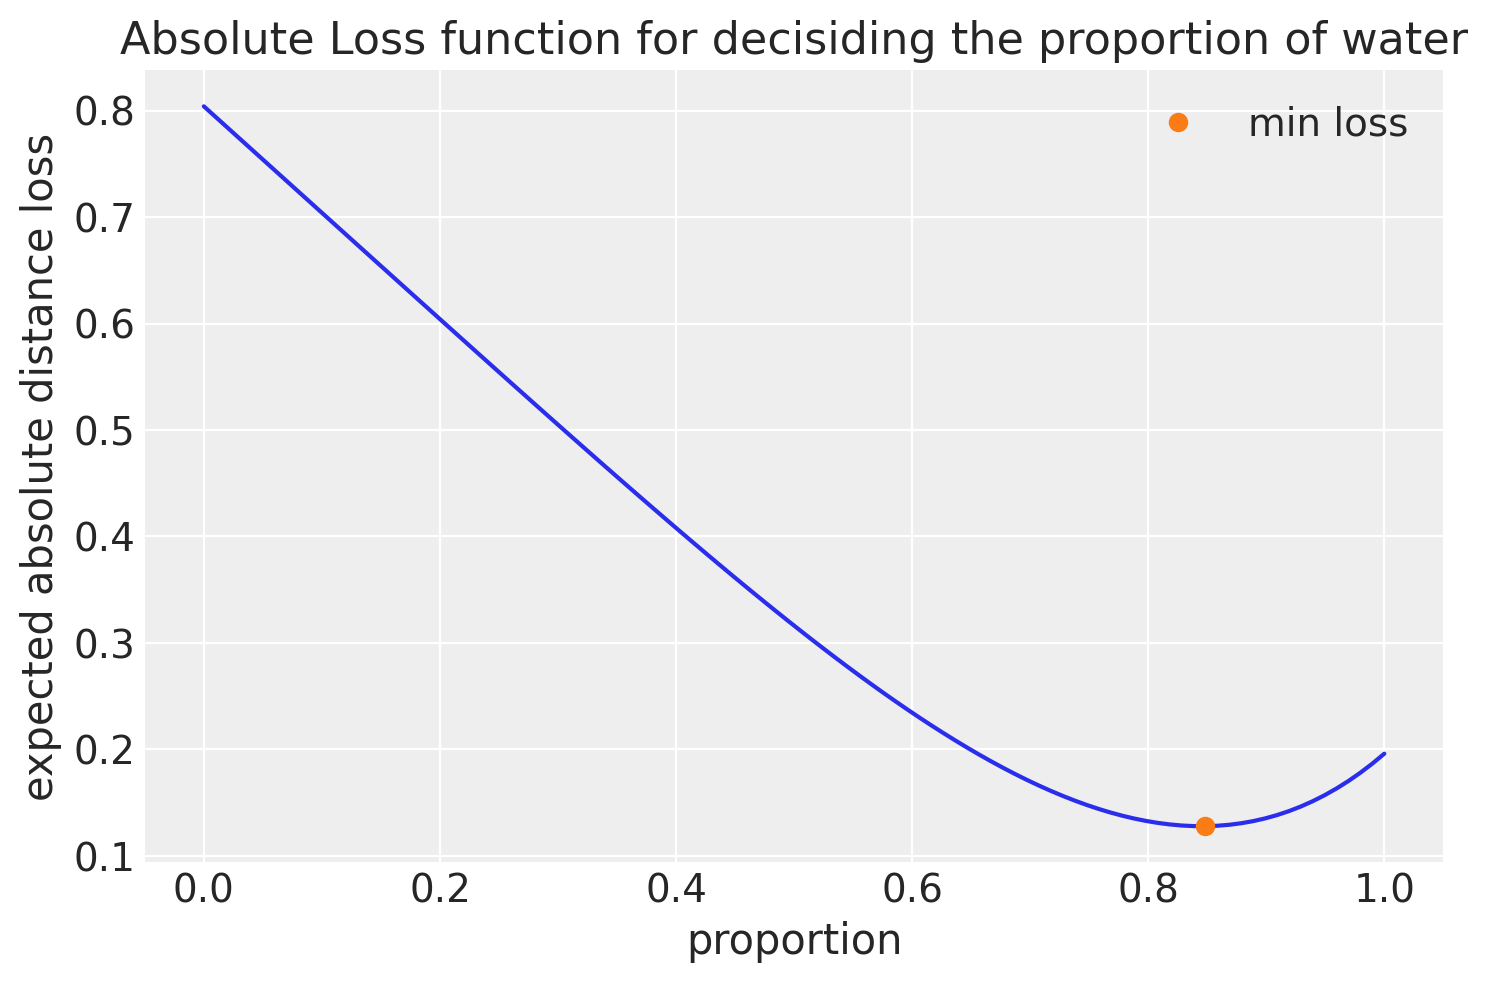

In [157]:
plt.plot(p_grid, loss);
plt.plot(p_grid[min_i], loss[min_i], 'o', label='min loss');
plt.title('Absolute Loss function for decisiding the proportion of water');
plt.xlabel('proportion');
plt.ylabel('expected absolute distance loss');
plt.legend();

## 3.3. Sampling to simulate prediction

Another common job of samples is to ease simulation of the model's implied observations. Generating implied observations from a model is useful for at least four distinct reasons.

1. **Model design.** We can sample not only from the posterior, but also from the prior. Seeing what the model expects, before the data arrive, is the best way to understand the implications of the prior model. But joint implications of multiple parameters are not always clear.
2. **Model checking** After a model is updated using data, it is worth simulating implied observations,
    1. to check whether the fit worked correctly
    2. and to investigate model behavior.
3. **Software validation** In order to be sure that our model fitting software is working (or not), it helps to simulate observations under a known model and then attempt to recover the values of the parameters (of the known model) the data were simulated under.
4. **Research design** If you can simulate observations from your hypothesis, then you can evaluate whether the research design can be effective. In a narrow sense, this means doing power analysis, but the possibilities are much broader.
5. **Forecasting** Estimates can be used to simulate new predictions, for new cases and future observations. These forecasts can be useful as applied prediction, but also for model criticism and checks.

### 3.3.1 Dummy data = Simulated Data

The dummy data arises from a binomial likelihood:
$$
\mathrm{Pr}(W|N,p) = \frac{N!}{W!(N-W)!} p^W (1-p)^W
$$

Suppose $N=2$, two tosses of the globe, then there are only three possible observations: W=0, W=1, W=2. We can quickly comput the probability of each, for any given value of $p$.

#### Code 3.20

In [159]:
# when p=0.7, the probabilities for W=0,1,2
stats.binom.pmf(range(3), n=2, p=0.7)

array([0.09, 0.42, 0.49])

#### Code 3.21

In [170]:
# when p=0.7, simulate W given N=2, repeat 100 times
stats.binom.rvs(n=2, p=0.7, size=100)

array([1, 1, 1, 1, 2, 2, 2, 1, 2, 0, 2, 2, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2,
       1, 1, 1, 0, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 2, 2,
       2, 2, 1, 1, 0, 2, 2, 2, 2, 1, 0, 1, 2, 1, 1, 2, 1, 1, 2, 2, 2, 1,
       1, 1, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 1, 1, 2, 2, 1, 2,
       2, 2, 2, 1, 2, 1, 2, 1, 1, 1, 2, 1])

#### Code 3.22

In [171]:
stats.binom.rvs(n=2, p=0.7, size=10)

array([1, 1, 1, 2, 1, 2, 2, 1, 1, 2])

#### Code 3.23

In [172]:
dummy_w = stats.binom.rvs(n=2, p=0.7, size=int(1e5))
[(dummy_w == i).mean() for i in range(3)]

[0.08983, 0.42016, 0.49001]

#### Code 3.24, 3.25 and 3.26

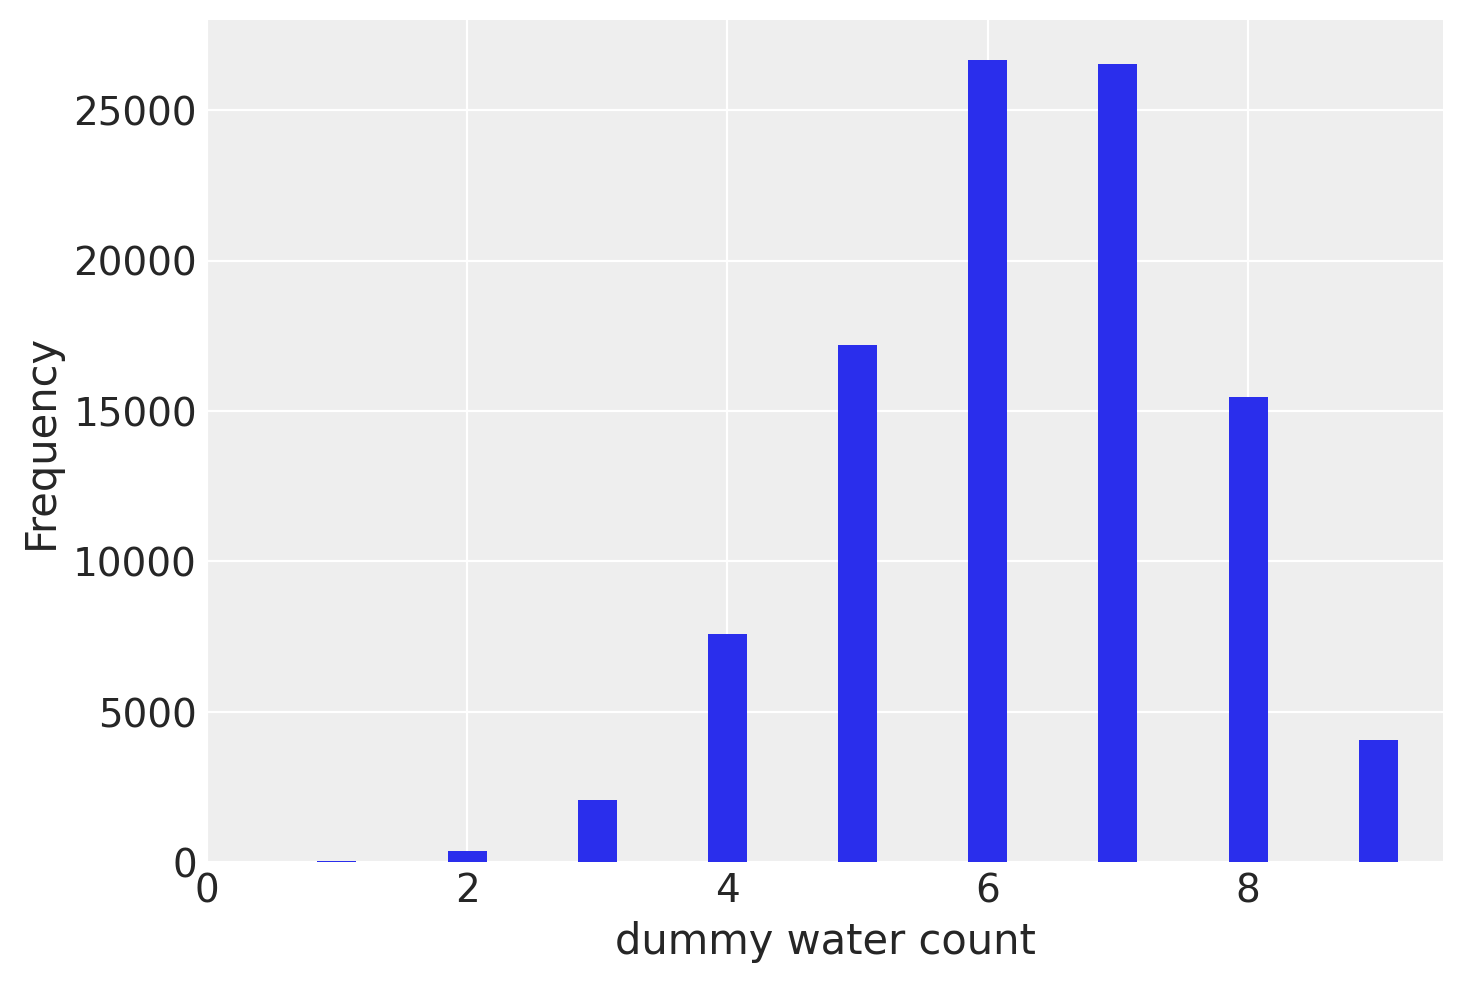

In [179]:
# N=9, p=0.7, simulation, plausible W=0:9
dummy_w = stats.binom.rvs(n=9, p=0.7, size=int(1e5))
# dummy_w = stats.binom.rvs(n=9, p=0.6, size=int(1e4))
# dummy_w = stats.binom.rvs(n=9, p=samples)

# PMF plot
bar_width = 0.3
plt.hist(dummy_w, bins=np.arange(0, 11) - bar_width / 2, width=bar_width) # carefully manipulated to plot PMF
plt.xlim(0, 9.5)
plt.xlabel("dummy water count")
plt.ylabel("Frequency");

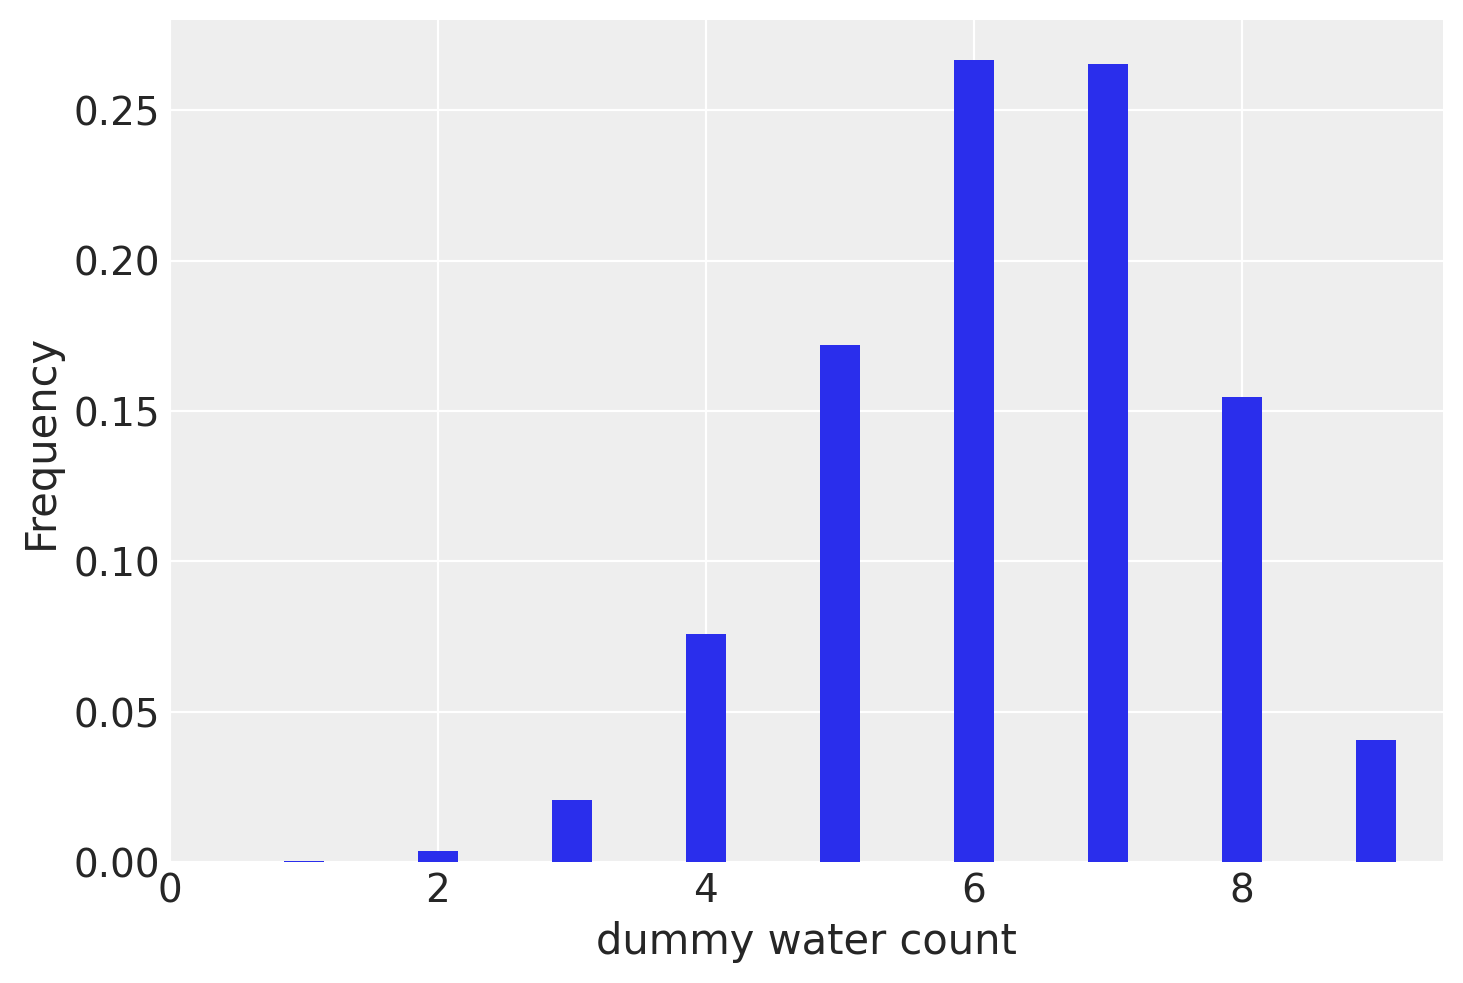

In [182]:
# PMF plot
bar_width = 0.3
plt.hist(dummy_w, bins=np.arange(0, 11) - bar_width / 2, width=bar_width, density=True) # carefully manipulated to plot PMF
plt.xlim(0, 9.5)
plt.xlabel("dummy water count")
plt.ylabel("Frequency");

### 3.3.2 Model Checking

#### 3.3.2.1 Did the software work?
#### 3.3.2.2 Is the model adequate?
- Every model is false. There is no true model.
- The goal is to assess exactly how the model fails to describe the data that are not well described by the model's expectations.


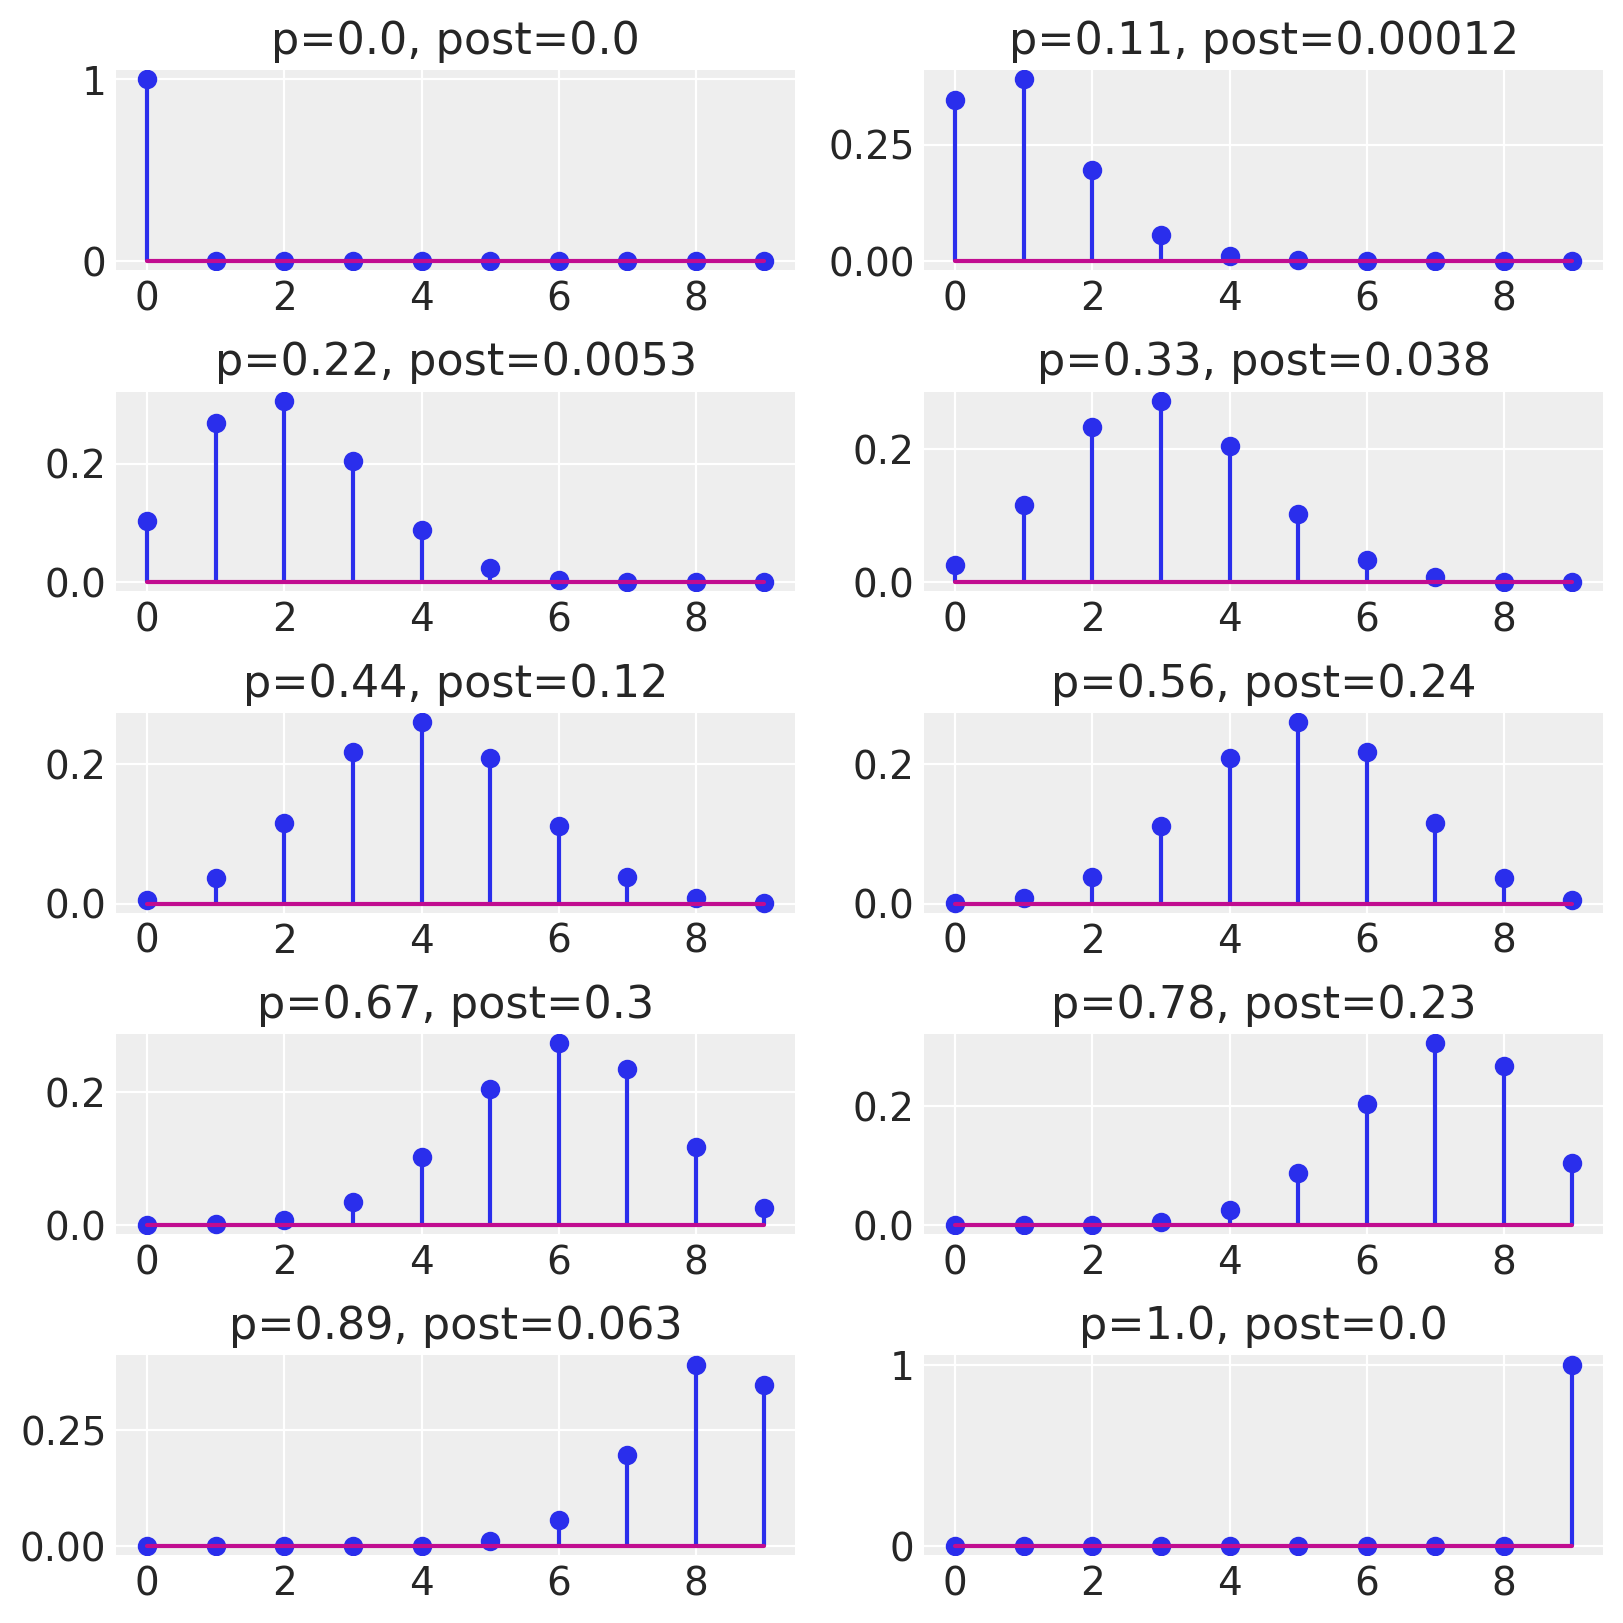

In [209]:
p_grid, posterior = posterior_grid_approx(grid_points=10, success=6, tosses=9)

n = 9  # tosses = 9
fig, axes = plt.subplots((n+1)//2, 2, figsize=(8, 8))
a = []  #(p, pmf)
for i, (p, ax) in enumerate(zip(p_grid, axes.ravel())):
    pmf = stats.binom.pmf(range(10), n=9, p=p) # PMF(W)
    a.append( (p, posterior[i], pmf) )
    ax.stem(range(10), pmf)  # the plot is the PMF(W) given p=p
    ax.set_title(f'p={p:.2}, post={posterior[i]:.2}')
#

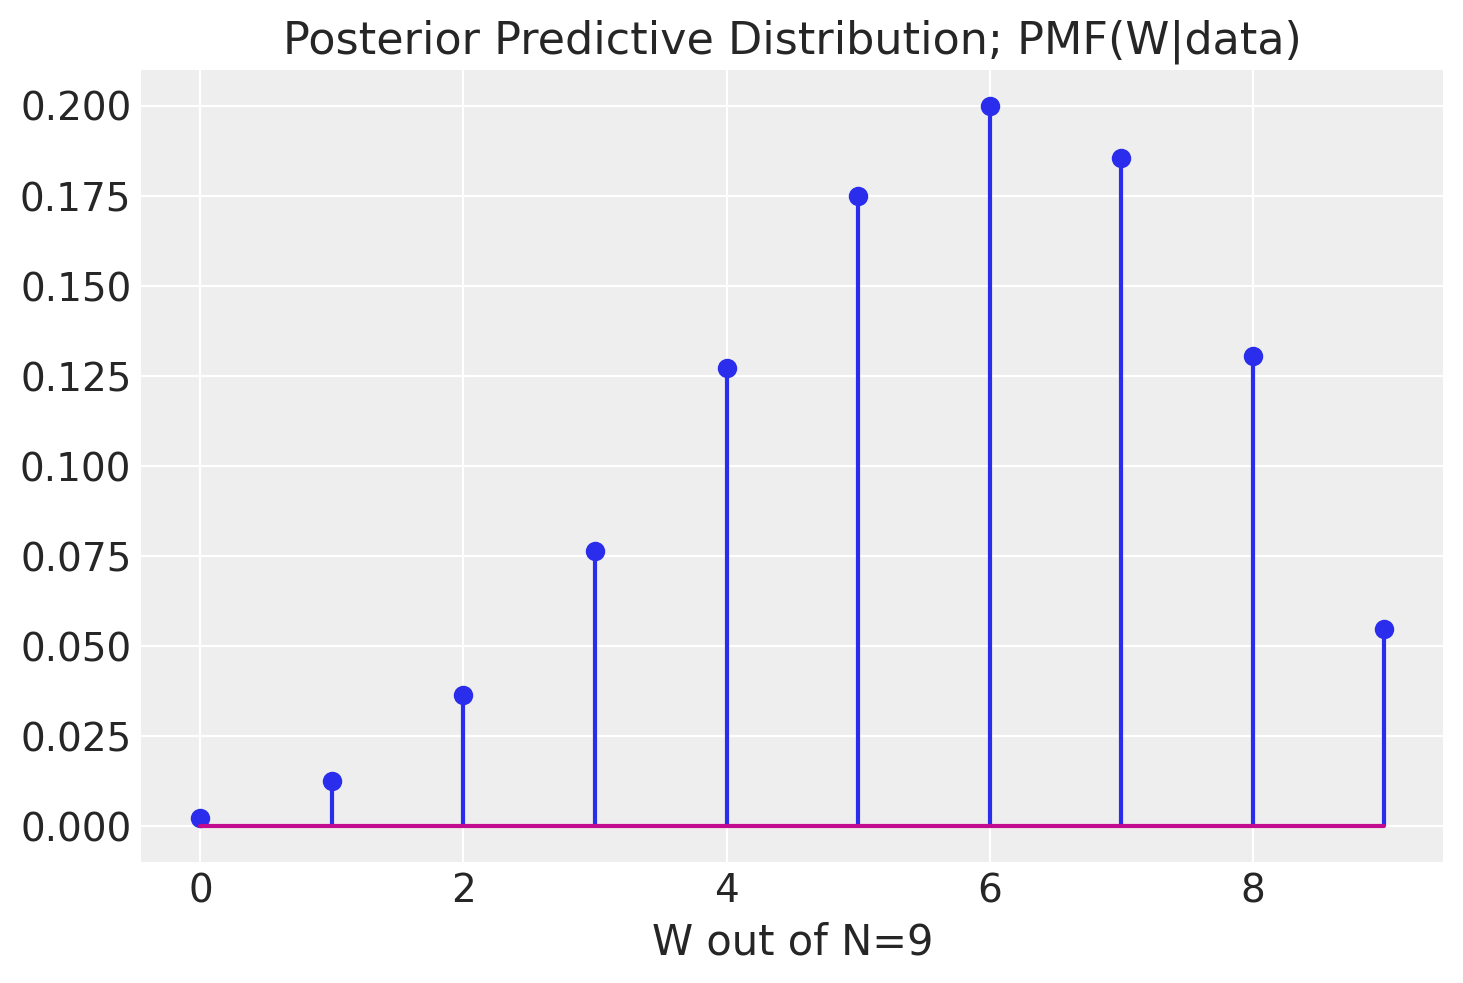

In [208]:
# now compute Posterior Predictive Distribution
posterior_predictive = np.zeros_like(posterior)
for ith in a:
    posterior_predictive += ith[1]*ith[2]
plt.stem(range(10), posterior_predictive)
plt.title('Posterior Predictive Distribution; PMF(W|data)');
plt.xlabel('W out of N=9');

**Notice.** Compared to PMF(W|p=0.67) the posterior predictive PMF(W|data, model) is apparently wider.

- The actual count of 6 (observation) lies right in the middle of the posterior predictive PMF.
- The spread arises from the binomial process, not from uncertainty about $p$.

- Always think about the assumption of independence of data samples, of each sample being completely independent of the others.

## 3.5. Practice

#### Code 3.27

In [183]:
p_grid, posterior = posterior_grid_approx(grid_points=100, success=6, tosses=9)
np.random.seed(100)
samples = np.random.choice(p_grid, p=posterior, size=int(1e4), replace=True)

#### Code 3.28

In [26]:
birth1 = np.array([1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,
                   1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1])
birth2 = np.array([0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0,
                   1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                   1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1,
                   0, 0, 0, 1, 1, 1, 0, 0, 0, 0])

#### Code 3.30

In [27]:
sum(birth1) + sum(birth2)

111

In [28]:
%watermark -n -u -v -iv -w

arviz 0.9.0
numpy 1.19.1
pymc3 3.9.2
last updated: Fri Jul 24 2020 

CPython 3.8.3
IPython 7.16.1
watermark 2.0.2
